In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('AMZN.csv')
data = data[['Date', 'Close', 'Low', 'High', 'Volume']]
data

,Date,Close,Low,High,Volume
0,1997-05-15,0.097917,0.096354,0.125000,1443120000
1,1997-05-16,0.086458,0.085417,0.098958,294000000
2,1997-05-19,0.085417,0.081250,0.088542,122136000
3,1997-05-20,0.081771,0.081771,0.087500,109344000
4,1997-05-21,0.071354,0.068750,0.082292,377064000
...,...,...,...,...,...
6511,2023-03-30,102.000000,101.010002,103.040001,53633400
6512,2023-03-31,103.290001,101.949997,103.489998,56704300
6513,2023-04-03,102.410004,101.430000,103.290001,41135700
6514,2023-04-04,103.949997,102.110001,104.199997,48662500


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

CLOSE_IND = 0
LOW_IND = 1
HIGH_IND = 2
VOLUME_IND = 3

OUT_VALUE = HIGH_IND

data = pd.read_csv('AMZN.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000
...,...,...,...,...,...,...,...
6511,2023-03-30,101.550003,103.040001,101.010002,102.000000,102.000000,53633400
6512,2023-03-31,102.160004,103.489998,101.949997,103.290001,103.290001,56704300
6513,2023-04-03,102.300003,103.290001,101.430000,102.410004,102.410004,41135700
6514,2023-04-04,102.750000,104.199997,102.110001,103.949997,103.949997,48662500


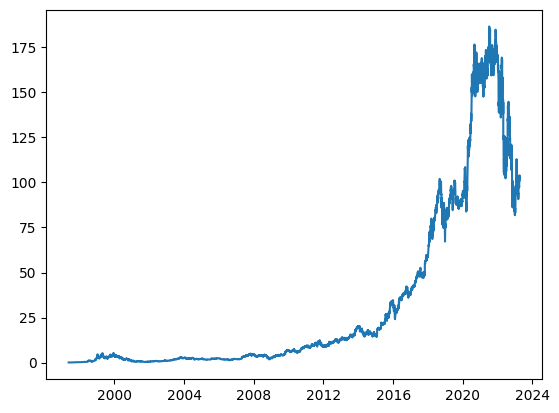

In [6]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [7]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.dropna(inplace=True)
        
    df1 = dc(df[['Date', 'Close']])
    df2 = dc(df[['Date', 'Low']])
    df3 = dc(df[['Date', 'High']])
    df4 = dc(df[['Date', 'Volume']])
    
    df1.set_index('Date', inplace=True)
    df2.set_index('Date', inplace=True)
    df3.set_index('Date', inplace=True)
    df4.set_index('Date', inplace=True)
    
    for i in range(1, n_steps+1):
        df1[f'Close(t-{i})'] = df1['Close'].shift(i)
        df2[f'Low(t-{i})'] = df2['Low'].shift(i)
        df3[f'High(t-{i})'] = df3['High'].shift(i)
        df4[f'Volume(t-{i})'] = df4['Volume'].shift(i)
        
    df1.dropna(inplace=True)
    df2.dropna(inplace=True)
    df3.dropna(inplace=True)
    df4.dropna(inplace=True)
    
    return df1, df2, df3, df4

lookback = 7
df1, df2, df3, df4 = prepare_dataframe_for_lstm(data, lookback)
df1



,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354
...,...,...,...,...,...,...,...,...
2023-03-30,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997,100.610001
2023-03-31,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999,98.699997
2023-04-03,102.410004,103.290001,102.000000,100.250000,97.239998,98.040001,98.129997,98.709999


In [8]:
df1_np = df1.to_numpy()
df2_np = df2.to_numpy()
df3_np = df3.to_numpy()
df4_np = df4.to_numpy()

df1_np

array([[7.91670000e-02, 7.50000000e-02, 6.97920000e-02, ...,
        8.54170000e-02, 8.64580000e-02, 9.79170000e-02],
       [7.65630000e-02, 7.91670000e-02, 7.50000000e-02, ...,
        8.17710000e-02, 8.54170000e-02, 8.64580000e-02],
       [7.52600000e-02, 7.65630000e-02, 7.91670000e-02, ...,
        7.13540000e-02, 8.17710000e-02, 8.54170000e-02],
       ...,
       [1.02410004e+02, 1.03290001e+02, 1.02000000e+02, ...,
        9.80400010e+01, 9.81299970e+01, 9.87099990e+01],
       [1.03949997e+02, 1.02410004e+02, 1.03290001e+02, ...,
        9.72399980e+01, 9.80400010e+01, 9.81299970e+01],
       [1.01099998e+02, 1.03949997e+02, 1.02410004e+02, ...,
        1.00250000e+02, 9.72399980e+01, 9.80400010e+01]])

In [33]:
from sklearn.preprocessing import MinMaxScaler

# scaler = [MinMaxScaler(feature_range=(-1, 1))]*4
# df1_np_scaled = scaler[CLOSE_IND].fit_transform(df1_np)
# df2_np_scaled = scaler[LOW_IND].fit_transform(df2_np)
# df3_np_scaled = scaler[HIGH_IND].fit_transform(df3_np)
# df4_np_scaled = scaler[VOLUME_IND].fit_transform(df4_np)

scaler1 = MinMaxScaler(feature_range=(-1, 1))
scaler4 = MinMaxScaler(feature_range=(-1, 1))
df1_np_scaled = scaler1.fit_transform(df1_np)
df2_np_scaled = scaler1.fit_transform(df2_np)
df3_np_scaled = scaler1.fit_transform(df3_np)
df4_np_scaled = scaler4.fit_transform(df4_np)

scaler = [scaler1, scaler1, scaler1, scaler4]

df1_np_scaled

array([[-0.99991063, -0.99995531, -1.        , ..., -0.99983244,
        -0.99982128, -0.99969839],
       [-0.99993855, -0.99991063, -0.99994415, ..., -0.99987154,
        -0.99983244, -0.99982128],
       [-0.99995253, -0.99993855, -0.99989946, ..., -0.99998325,
        -0.99987154, -0.99983244],
       ...,
       [ 0.09747299,  0.10690997,  0.09308121, ...,  0.0506149 ,
         0.05158   ,  0.05779984],
       [ 0.11398769,  0.09747299,  0.10691495, ...,  0.04203581,
         0.0506149 ,  0.05158   ],
       [ 0.08342464,  0.11398769,  0.09747802, ...,  0.07431453,
         0.04203581,  0.0506149 ]])

In [34]:
# X = np.array([df1_np[:, 1:], df2_np[:, 1:], df3_np[:, 1:], df4_np[:, 1:]])
# y = np.array([df1_np[:, 0], df2_np[:, 0], df3_np[:, 0], df4_np[:, 0]])

X = np.zeros((len(df1_np), 4 * lookback))
y = np.zeros((len(df1_np), 3))
for i in range(0,len(df1_np)):
    X[i] = np.hstack((df1_np_scaled[i,1:], df2_np_scaled[i,1:], df3_np_scaled[i,1:], df4_np_scaled[i,1:]))
    y[i] = np.hstack((df1_np_scaled[i,0], df2_np_scaled[i,0], df3_np_scaled[i,0]))

X.shape, y.shape

((6509, 28), (6509, 3))

In [35]:
X = dc(np.flip(X, axis=1)) #flip left right
X

array([[ 0.38034321, -0.72626105, -0.89176634, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.72626105, -0.89176634, -0.90408505, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.89176634, -0.90408505, -0.6462703 , ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [-0.9539538 , -0.95536353, -0.96439081, ...,  0.07431453,
         0.09308121,  0.10690997],
       [-0.95536353, -0.96439081, -0.97209597, ...,  0.09308121,
         0.10691495,  0.09747299],
       [-0.96439081, -0.97209597, -0.96144209, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [36]:
split_index = int(len(X) * 0.95)

split_index

6183

In [37]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 28), (326, 28), (6183, 3), (326, 3))

In [38]:
X_train = X_train.reshape((-1, lookback*4, 1))
X_test = X_test.reshape((-1, lookback*4, 1))

y_train = y_train.reshape((-1, 3))
y_test = y_test.reshape((-1, 3))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6183, 28, 1), (326, 28, 1), (6183, 3), (326, 3))

In [39]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6183, 28, 1]),
 torch.Size([326, 28, 1]),
 torch.Size([6183, 3]),
 torch.Size([326, 3]))

In [40]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [41]:
train_dataset

In [42]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 28, 1]) torch.Size([16, 3])


In [44]:
from CHLpredictor import CHLpredictor

model = CHLpredictor(device, 1, 4, 1, 3)
model.to(device)
model

CHLpredictor(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=3, bias=True)
  (loss_function): MSELoss()
)

In [45]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [46]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [47]:
learning_rate = 0.001
num_epochs = 100
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    torch.save(model.state_dict(), "checkpoints/chkpoint_" + str(epoch) + ".pt")

Epoch: 1
Batch 100, Loss: 0.321
Batch 200, Loss: 0.238
Batch 300, Loss: 0.129

Val Loss: 0.187
***************************************************

Epoch: 2
Batch 100, Loss: 0.037
Batch 200, Loss: 0.022
Batch 300, Loss: 0.015

Val Loss: 0.022
***************************************************

Epoch: 3
Batch 100, Loss: 0.006
Batch 200, Loss: 0.004
Batch 300, Loss: 0.002

Val Loss: 0.006
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001
Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.003
******************

(6183, 3)


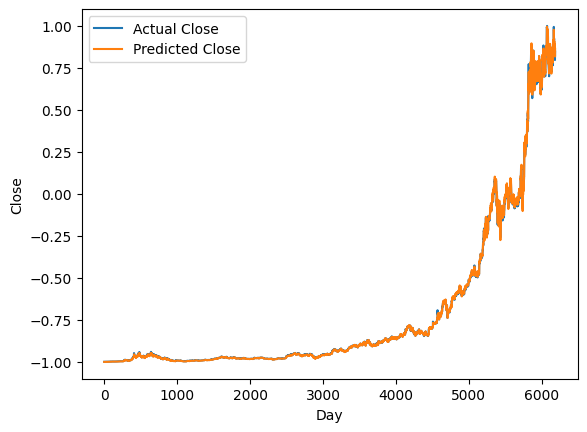

In [49]:
model.load_state_dict(torch.load("checkpoints/chkpoint_99.pt"))
model.eval()

with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

print(predicted.shape)

plt.plot(y_train[:,OUT_VALUE], label='Actual Close')
plt.plot(predicted[:,OUT_VALUE], label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Translate back to real prices

In [50]:
train_predictions = predicted[:,OUT_VALUE].flatten()
print(train_predictions.shape, X_train.shape)

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions

dummies = scaler[OUT_VALUE].inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

(6183,) torch.Size([6183, 28, 1])


array([5.48655555e-03, 7.85824108e-03, 7.01522490e-03, ...,
       1.71881166e+02, 1.71495053e+02, 1.75774507e+02])

In [51]:
X_train.shape, y_train.shape

(torch.Size([6183, 28, 1]), torch.Size([6183, 3]))

In [52]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train[:, OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([8.22909500e-02, 8.17682799e-02, 7.70811100e-02, ...,
       1.69498993e+02, 1.73600008e+02, 1.74165998e+02])

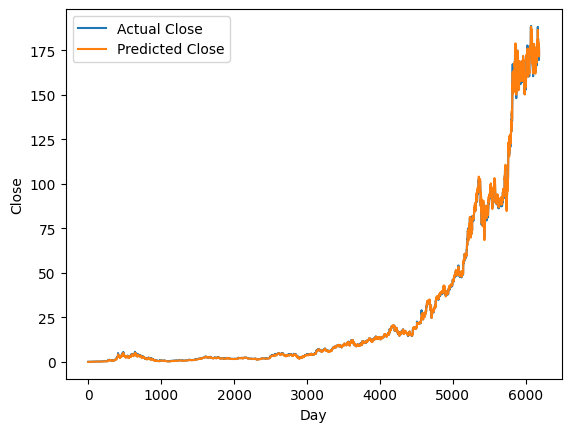

In [53]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [54]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy()
test_predictions = test_predictions[:,OUT_VALUE].flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([171.40707611, 172.33588886, 169.53189339, 172.85581628,
       173.5996488 , 173.50832205, 172.06450509, 173.05445338,
       171.66285846, 171.07063397, 169.1697786 , 172.89918103,
       170.08268645, 166.68265606, 165.69039229, 165.12697647,
       164.06020131, 168.07630793, 167.89908345, 163.58244718,
       164.62875391, 161.41172547, 158.69425718, 153.93480138,
       144.29565317, 147.22596619, 142.34066492, 141.30904635,
       142.38902033, 147.10402109, 152.81755765, 154.09147874,
       153.16559969, 140.08457658, 161.06309894, 161.28667807,
       164.083255  , 163.76408907, 161.3801517 , 155.38201288,
       157.79970461, 159.38630603, 160.91709977, 157.11365804,
       154.97184616, 152.6170884 , 146.93705892, 154.45485244,
       156.90552296, 156.25387145, 153.5412477 , 154.67349712,
       150.22404646, 147.96669641, 139.13240666, 138.28120198,
       142.33014408, 150.31200115, 148.27914068, 143.97160899,
       150.35038649, 156.34844663, 160.25583788, 164.08

In [55]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test[:,OUT_VALUE].flatten()
dummies = scaler[OUT_VALUE].inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([170.89850131, 167.87449548, 170.71650535, 172.05000521,
       171.97500487, 172.9429954 , 172.17599679, 171.21200779,
       170.88799733, 169.35000422, 170.70350604, 171.39999477,
       167.12649284, 164.80000421, 165.24349817, 161.66149993,
       166.35000749, 166.87800539, 166.2214981 , 162.24999828,
       159.73449419, 159.25000155, 157.99999964, 150.8999937 ,
       144.94500606, 143.60000746, 145.18499591, 144.24349857,
       143.99800102, 150.36050268, 151.70799099, 155.07499762,
       144.24750009, 161.19999915, 162.69099129, 161.7924934 ,
       163.8345034 , 160.71650688, 159.00000229, 158.44850111,
       158.00700229, 158.83400117, 160.34899679, 155.49949561,
       152.98249657, 151.7630006 , 151.74899529, 153.9900077 ,
       154.44999667, 154.09899845, 152.9994974 , 153.92900142,
       147.85000611, 146.09449797, 140.69949226, 140.24999884,
       148.67449841, 149.67500126, 147.44999493, 147.9850011 ,
       153.14999265, 157.49850617, 161.59399681, 163.08

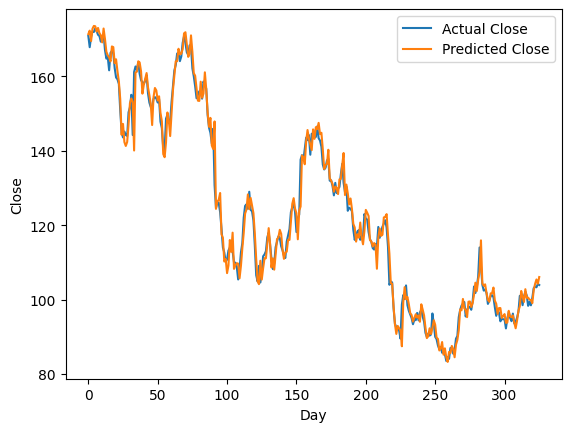

In [56]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


Root Mean Square Error:  0.17019417847452925 %
Std: 1.7149308696831789 %


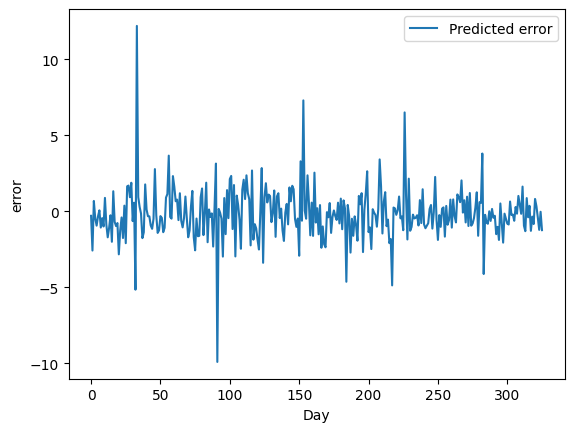

In [57]:
import math

MSE = np.square(np.subtract(new_y_test,test_predictions).mean()) 
 
RMSE = math.sqrt(MSE)
RMSE_pec = RMSE / new_y_test.max() * 100
print("Root Mean Square Error: ", RMSE_pec, "%")

print("Std:", np.subtract(new_y_test,test_predictions).std()/new_y_test.max()*100, "%")

plt.plot(np.subtract(new_y_test,test_predictions)/new_y_test.max()*100, label='Predicted error')
plt.xlabel('Day')
plt.ylabel('error')
plt.legend()
plt.show()